# Recommendation System Using Streaming Data

source: https://www.datacamp.com/tutorial/streaming-platform-analysis 

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import RegexpTokenizer
# import numpy as np
from sklearn import preprocessing
from scipy.sparse import hstack
# import pandas_profiling

In [2]:
# Load the dataset
df = pd.read_csv('tvshows.csv')
df = df.iloc[:,1:] # removes the unnamed index column

## 1. Data Exploration

In [3]:
df.head()

,ID,Title,Year,Age,Rotten Tomatoes,Netflix,Hulu,Prime Video,Disney+,Type
0,1,The Irishman,2019,18+,98/100,1,0,0,0,0
1,2,Dangal,2016,7+,97/100,1,0,0,0,0
2,3,David Attenborough: A Life on Our Planet,2020,7+,95/100,1,0,0,0,0
3,4,Lagaan: Once Upon a Time in India,2001,7+,94/100,1,0,0,0,0
4,5,Roma,2018,18+,94/100,1,0,0,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9515 entries, 0 to 9514
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   ID               9515 non-null   int64 
 1   Title            9515 non-null   object
 2   Year             9515 non-null   int64 
 3   Age              5338 non-null   object
 4   Rotten Tomatoes  9508 non-null   object
 5   Netflix          9515 non-null   int64 
 6   Hulu             9515 non-null   int64 
 7   Prime Video      9515 non-null   int64 
 8   Disney+          9515 non-null   int64 
 9   Type             9515 non-null   int64 
dtypes: int64(7), object(3)
memory usage: 743.5+ KB


In [5]:
df.Type.unique()

array([0])

#### Find Missing Values in the Data

In [6]:
miss = pd.DataFrame(df.isnull().sum())
miss = miss.rename(columns={0:"miss_count"})
miss["miss_%"] = (miss.miss_count/len(df.ID))*100
miss

,miss_count,miss_%
ID,0,0.000000
Title,0,0.000000
Year,0,0.000000
Age,4177,43.899107
Rotten Tomatoes,7,0.073568
Netflix,0,0.000000
Hulu,0,0.000000
Prime Video,0,0.000000
Disney+,0,0.000000
Type,0,0.000000


There are 4k missing values in the `Age` column, which is nearly half of the dataset. The `Rotten Tomatoes` Column is only missing 7 rows so we will just drop those. The remaining columns have no nulls.

In [7]:
df.dropna(subset=['Rotten Tomatoes'], inplace=True)

In [8]:
# take a closer look at the age column
print(df['Age'].value_counts())
dist = df['Age'].value_counts(normalize=True)

Age
18+    2276
7+     1090
13+     998
all     698
16+     276
Name: count, dtype: int64


There are currently five different categories in the `Age` column. These represent the recommended age range for viewers. Since it is a string, we cannot apply null padding using the median value. The next best option would be to use the most common value which appears to be 18+, but that would mean around 75% of the movies in this dataset are rated R. Instead, we either want to fill with the same distribution of labels that is currently present, or set them to 'unknown'. 

In [9]:
# Apply a similar distribution of values to the Age column
# Stack Overflow: https://stackoverflow.com/questions/44867219/pandas-filling-na-values-to-be-filled-based-on-distribution-of-existing-values 
missing = df['Age'].isnull()
df.loc[missing,'Age'] = np.random.choice(dist.index, size=len(df[missing]), p=dist.values)

In [10]:
# Make sure it worked
print(df['Age'].isnull().value_counts())

Age
False    9508
Name: count, dtype: int64


In [11]:
df.reset_index(inplace=True, drop=True)
# Convert year to an object type
df.Year = df.Year.astype("object")

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9508 entries, 0 to 9507
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   ID               9508 non-null   int64 
 1   Title            9508 non-null   object
 2   Year             9508 non-null   object
 3   Age              9508 non-null   object
 4   Rotten Tomatoes  9508 non-null   object
 5   Netflix          9508 non-null   int64 
 6   Hulu             9508 non-null   int64 
 7   Prime Video      9508 non-null   int64 
 8   Disney+          9508 non-null   int64 
 9   Type             9508 non-null   int64 
dtypes: int64(6), object(4)
memory usage: 742.9+ KB


#### Exploring the Clean Data

/opt/anaconda3/envs/RecSystem/lib/python3.13/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Figure size 2000x500 with 0 Axes>

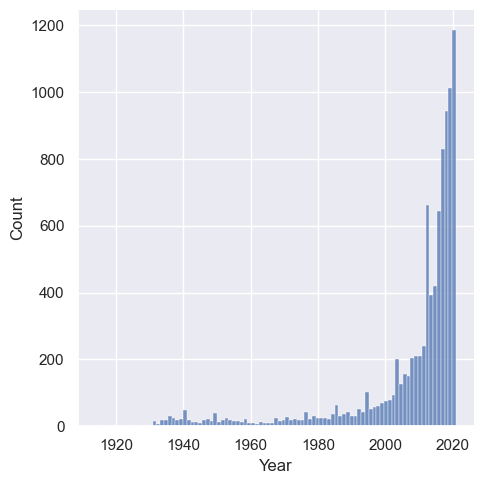

In [13]:
# Check distribution of the years
plt.figure(figsize=(20,5))
sns.set_theme(color_codes="g")
sns.displot(df['Year'])

We can see that most of the movies in this dataset were made between 2000 and 2020.

/opt/anaconda3/envs/RecSystem/lib/python3.13/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Figure size 2000x2000 with 0 Axes>

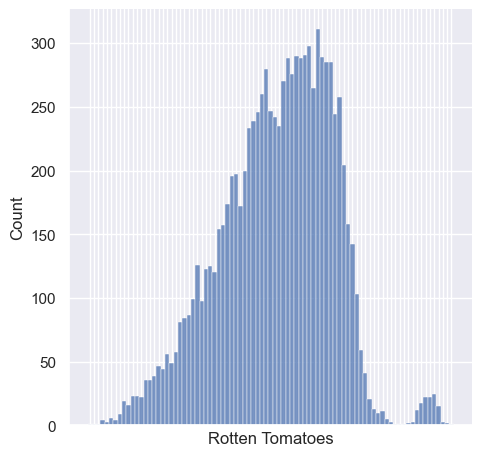

In [14]:
# plot distribution of Rotten Tomatoes scores
plt.figure(figsize=(20,20))
sns.displot(df['Rotten Tomatoes'])
plt.tick_params(
        axis='x',
        which='both',
        bottom=False,
        top=False,
        labelbottom=False
)
plt.show()

Rottom tomatoes scores range from 0 to 100%. This looks pretty close to a normal distribution, with roughly 60% of the values being between 40 and 60 percent. It is slightly skewed towards the right, meaning more scores are above 50 than below, but it is pretty close. 

#### Get the Distribution of Movies on each Streaming Platform

In [15]:
# Define a function to calculate the movies in different Streaming platforms
def m_cnt(plat, count=False):
    if count==False:
        print('Platform {} Count: {}'. format(plat, df[plat].sum()))
    else:
        return df[plat].sum()


In [16]:
# Let's see count of movies/shows of each streaming platform
m_cnt('Netflix')
m_cnt('Hulu')
m_cnt('Prime Video')
m_cnt('Disney+')

Platform Netflix Count: 3688
Platform Hulu Count: 1047
Platform Prime Video Count: 4113
Platform Disney+ Count: 922


Netflix = 3,688

Hulu = 1,047

Prime Video = 4,113

Disney+ = 922

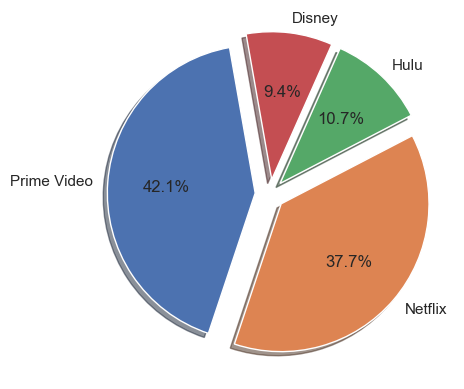

In [17]:
# Movies on each platform
lab = 'Prime Video','Netflix', 'Hulu', 'Disney'
s = [m_cnt('Prime Video', count=True),
     m_cnt('Netflix', count=True),
     m_cnt('Hulu', count=True),
     m_cnt('Disney+', count=True)]

explode = (0.1, 0.1, 0.1, 0.1)

#plotting
fig1, ax1 = plt.subplots()
ax1.pie(s,
       labels = lab,
       autopct = '%1.1f%%',
       explode = explode,
       shadow = True,
       startangle = 100)

ax1.axis = ('equal')
plt.show()


#### Rotten Tomatoes Rating Distributions for Each Platform

In [18]:
 # melting platform columns to create visualization
df2 = pd.melt(df, id_vars=["ID","Title","Year", "Age", "Rotten Tomatoes", "Type"], var_name="platform")
df2 = df2[df2.value==1]
df2.drop(columns=["value"],axis=1,inplace=True)

In [19]:
df2.head()

,ID,Title,Year,Age,Rotten Tomatoes,Type,platform
0,1,The Irishman,2019,18+,98/100,0,Netflix
1,2,Dangal,2016,7+,97/100,0,Netflix
2,3,David Attenborough: A Life on Our Planet,2020,7+,95/100,0,Netflix
3,4,Lagaan: Once Upon a Time in India,2001,7+,94/100,0,Netflix
4,5,Roma,2018,18+,94/100,0,Netflix


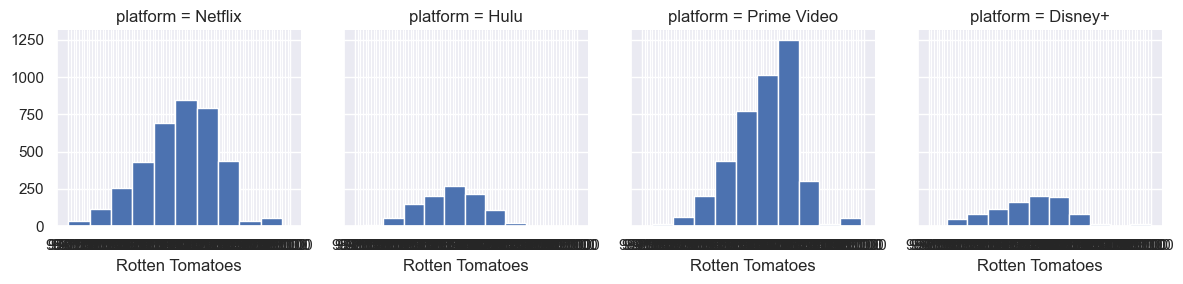

In [20]:
# Distribution of IMDB rating in different platform
g = sns.FacetGrid(df2, col = "platform")
g.map(plt.hist, "Rotten Tomatoes")
plt.show()

The platforms with the most data also have the richest distributions of reviews. In general, it looks like a Prime Video movie is the most likely to receive a rating higher than 50%, while the Disney+ platform is more likely to receive a rating below 50%. 

## Building the Recommender Systems

A **recommendation system** is a class of machine learning that uses data to help predict, narrow down, and fid what people are looking for among an exponentialy growing number of options. The system uses data like past purchases, search history (cookies), demographic information, and other factors to suggest the best products for each user. There are two main types of recommendation systems: 
1) **Collaborative Filtering:** an algorithm that recommends items based on preferential information collected from many users. It is inspired by the concept that a group of people who make similar decisions in the past are highly likely to make similar decisions in the future.

2) **Content Filtering:** an algorithm that uses attributes or features of an item to recommend other similar items. The underlying idea for this approach is that you will continue to prefer things that are similar to what you currently like. 

### 1. Recommender System Using only the Numerical Column

In [21]:
ndf = df.select_dtypes(include=['float64', 'int64'])

#### Scaling the numerical variable using a min-max scaler to reduce model complexity and training time

In [22]:
#importing minmax scaler
from sklearn import preprocessing

# Create MinMaxScaler Object
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))

# Create dataframe after transformation
ndfmx = pd.DataFrame((scaler.fit_transform(ndf)))

# assign column names
ndfmx.columns=ndf.columns

# Show initial 5 records
ndfmx.head()

,ID,Netflix,Hulu,Prime Video,Disney+,Type
0,0.000000,1.0,0.0,0.0,0.0,0.0
1,0.000105,1.0,0.0,0.0,0.0,0.0
2,0.000210,1.0,0.0,0.0,0.0,0.0
3,0.000315,1.0,0.0,0.0,0.0,0.0
4,0.000420,1.0,0.0,0.0,0.0,0.0


#### Compute similarity using Cosine Similarity

In [23]:
# Import cosine similarity
from sklearn.metrics.pairwise import cosine_similarity

# Compute the cosine similarity
sig = cosine_similarity(ndfmx, ndfmx)

# Reverse mapping of indices and movie titles
indices = pd.Series(df.index, index=df['Title']).drop_duplicates()


In [24]:
indices.head()

Title
The Irishman                                0
Dangal                                      1
David Attenborough: A Life on Our Planet    2
Lagaan: Once Upon a Time in India           3
Roma                                        4
dtype: int64

#### Write a function to get recommendations based on the similarity score
* The function will take in two arguments
    1) movie title
    2) similarity score
* Gets the pairwise similarity scores of all the movies
* Sorts the similarity scores in descending order and converts them into a list
* Gets the top 10 movies scores and indices and returns the titles from our original dataframe

In [25]:
def give_rec(title, sig=sig):

    # Get the index corresponding to original_title
    idx = indices[title]

    # Get the pairwise similarity scores
    sig_scores = list(enumerate(sig[idx]))

    # Sort the movies
    sig_scores = sorted(sig_scores, key=lambda x: x[1], reverse=True)

    # Scores of the 10 most similar movies
    sig_scores = sig_scores[1:11]

    # Movie indices
    movie_indices = [i[0] for i in sig_scores]

    # Top 10 most similar movies
    return df['Title'].iloc[movie_indices]


In [28]:
# Execute get_rec() function for getting recommendation
give_rec("Moana",sig = sig)

8647                                  Hidden Figures
8645                                         Ant-Man
8648                                          Frozen
8644                                         Aladdin
8649    Star Wars: Episode III - Revenge of the Sith
8643                                     Toy Story 2
8650                                  Wreck-It Ralph
8642                                      Big Hero 6
8651                                   Incredibles 2
8641                              The Princess Bride
Name: Title, dtype: object

With this approach, we are only using the platform, type, and ID to make a recommendation. It is not based on the rating of the movie, who the intended audience is, or even the genre. These additional features, which are usually categorical, will go a long way towards improving our recommender model. 

### 2. Recommender System Using Numerical and Textual Columns

In [29]:
df.head()

,ID,Title,Year,Age,Rotten Tomatoes,Netflix,Hulu,Prime Video,Disney+,Type
0,1,The Irishman,2019,18+,98/100,1,0,0,0,0
1,2,Dangal,2016,7+,97/100,1,0,0,0,0
2,3,David Attenborough: A Life on Our Planet,2020,7+,95/100,1,0,0,0,0
3,4,Lagaan: Once Upon a Time in India,2001,7+,94/100,1,0,0,0,0
4,5,Roma,2018,18+,94/100,1,0,0,0,0


For this approach, we will create a new column that stores all of the text information as a long concatenated string. This information can then be passed into a TF-IDF Vectorizer to ceate a sparse matrix of all the words' TF-IDF scores. 

In [42]:
# this function performs all the important processing steps
def preprocess(df):
    # combine all the text columns
    # First, select all object data types and store them in a list
    s = list(df.select_dtypes(include=['object']).columns)
    # Second, remove the ID and Title columns
    s.remove('Title')
    # Third, Join all text/object columns using commas into a single column
    df['all_text'] = df[s].apply(lambda x: ','.join(x.dropna().astype(str)),axis=1)


    # Build TfidfVectorizer from the text
    cv = TfidfVectorizer(lowercase=True, stop_words='english', ngram_range=(1,1))
    text_counts = cv.fit_transform(df['all_text'])

    # Select numerical variables
    ndf = df.select_dtypes(include=['float64', 'int64'])

    # Scale numerical variables
    scaler = preprocessing.MinMaxScaler(feature_range=(0,1))

    # Apply scaler to our data and convert it into a dataframe
    ndfmx = pd.DataFrame((scaler.fit_transform(ndf)))
    ndfmx.columns=ndf.columns

    # Add numerical variables in the TF-IDF vector
    Netflix = ndfmx.Netflix.values[:, None]
    X_train_dtm = hstack((text_counts, Netflix))
    Hulu = ndfmx.Hulu.values[:, None]
    X_train_dtm = hstack((X_train_dtm, Hulu))
    Prime = ndfmx["Prime Video"].values[:, None]
    X_train_dtm = hstack((X_train_dtm, Prime))
    Disney = ndfmx["Disney+"].values[:, None]
    X_train_dtm = hstack((X_train_dtm, Disney))

    return X_train_dtm
    

#### Apply the Function to our Data and Create a Sparse Matrix

In [43]:
mat = preprocess(df)
mat.shape

(9508, 194)

#### Apply Cosine Similarity to Compute the Similarity Scores

In [44]:
# Compute the sigmoid kernel
sig2 = cosine_similarity(mat, mat)

# Reverse the mapping of indices and movie titles
indices = pd.Series(df.index, index=df['Title']).drop_duplicates()

#### Get a Recommendation From the Improved System

In [45]:
give_rec('Moana', sig=sig2)

8647                                  Hidden Figures
8651                                   Incredibles 2
8648                                          Frozen
8650                                  Wreck-It Ralph
8652                                         Tangled
8653                                      Iron Man 3
8649    Star Wars: Episode III - Revenge of the Sith
8654                  The Nightmare Before Christmas
9341                               Drain the Titanic
9405                           Drain The Ocean: WWII
Name: Title, dtype: object

## Conclusion

This project was originally created to work with the same Kaggle dataset, only it had more features, including genre and IMDb ratings. While the new version of this streaming dataset is much less detailed, there are still a sufficient number of movie attributes provided to understand how the content-based filtering method was applied and improved with the addition of textual details. Next steps are to apply what I learned in this project to the recommendation system I will be building for the Personal Shopper AI project. 